# NHL Goal Scoring Data Analysis

## Import libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

/Users/brendanlai/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import data
And also adding in some other interesting fields I wanted to look into

In [3]:
playsDF = pd.read_csv('NHL_GameData/game_plays.csv')

# retyping dates
playsDF['dateTime'] = pd.to_datetime(playsDF['dateTime'])

In [11]:
goalsDF = playsDF[playsDF['event'] == "Goal"]

print(f"From {goalsDF['dateTime'].dt.date.min()} to {goalsDF['dateTime'].dt.date.max()} there have been {len(goalsDF)} goals across the NHL")

From 2000-10-05 to 2020-09-29 there have been 148992 goals across the NHL


In [26]:
def assistsOnGoal(df):
    s = str(df['description']).split('assists')[-1] # get assist info from description field
    if "none" in s:
        return 0
    elif "," in s:
        return 2
    else:
        return 1
    
goalsDF['numAssistsOnGoals'] = goalsDF.apply(assistsOnGoal, axis=1)


In [87]:
NET_COORD = [90, 0]
def goalProximity(df):
    if df['st_x'] is not None:
        return np.sqrt((df['st_x']- NET_COORD[0]) ** 2 + (df['st_y'] - NET_COORD[1]) ** 2) 

goalsDF['shotProximity'] = goalsDF.apply(goalProximity, axis=1)

/var/folders/4r/cft4fvnn6nj574npdkm_87z40000gn/T/ipykernel_34878/3760065620.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goalsDF['shotProximity'] = goalsDF.apply(goalProximity, axis=1)


## Analysis 
Looked into:
- shot proximity for goals
- goals scored per game over time (yearly)
- heatmaps for the goals scored over years with location information

Text(0, 0.5, 'Count')

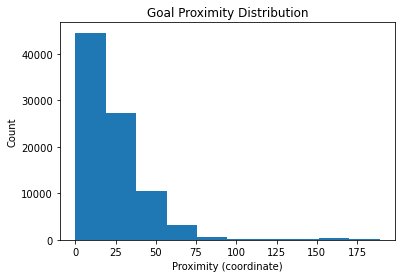

In [90]:
# Distribution of net proximity for goals scored
plt.hist(goalsDF.shotProximity)
plt.title("Goal Proximity Distribution")
plt.xlabel("Proximity (coordinate)")
plt.ylabel("Count")

Text(0.5, 1.0, 'Goals scored per game over time (years)')

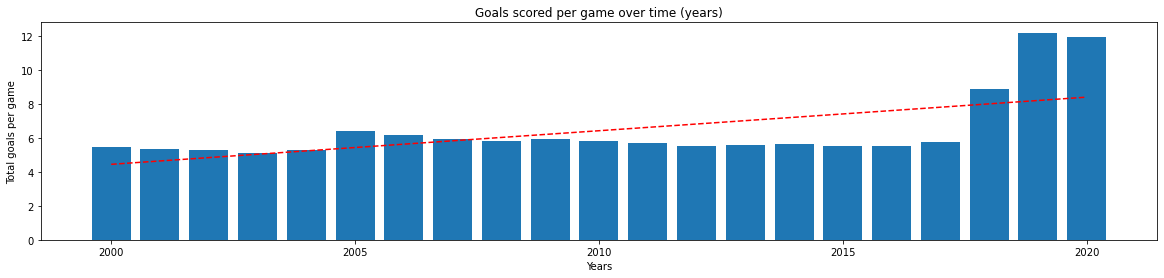

In [89]:
# Calculate the number of games each year

gameIDs = playsDF.game_id.unique()
gameCounterDf = playsDF[playsDF['game_id'].isin(gameIDs)].drop_duplicates(['game_id'])

tmp = [g for n, g in gameCounterDf.groupby(pd.Grouper(key='dateTime',freq='Y'))]
numGamesYearly = []
for x in tmp:
    numGamesYearly.append(len(x)) # store the number of games each year in a list

# Calculate the number of goals each year
yearlyGoalGroups = [g for n, g in goalsDF.groupby(pd.Grouper(key='dateTime',freq='Y'))]
yearIndex = []
yearGoalPGame = []

for i in range (0, len(yearlyGoalGroups)):

    yearIndex.append(yearlyGoalGroups[i]['dateTime'].iloc[-1].year)
    yearGoalPGame.append(len(yearlyGoalGroups[i])/ numGamesYearly[i])

# Calculate trend using quadratic polynomial
z = np.polyfit(yearIndex, yearGoalPGame, 1)
p = np.poly1d(z)

# plot goals scored per game in each year
plt.figure().set_figwidth(20)
plt.plot(yearIndex, p(yearIndex), color='red', linestyle='dashed')
plt.bar(yearIndex, yearGoalPGame)
plt.ylabel("Total goals per game")
plt.xlabel("Years")
plt.title("Goals scored per game over time (years)")

In [59]:
# Get the goals with location data
goalLocDF = goalsDF[goalsDF.x.notna()]

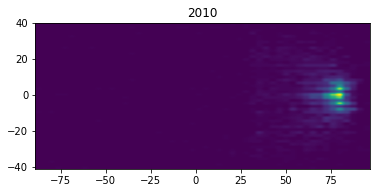

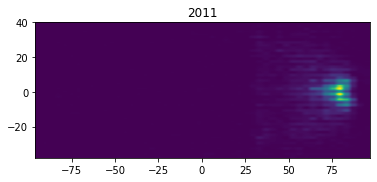

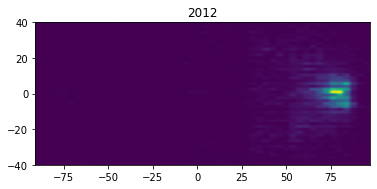

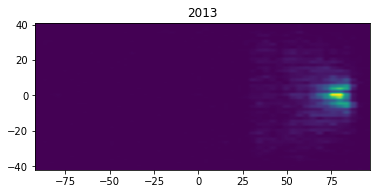

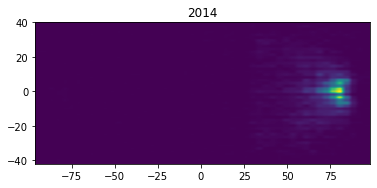

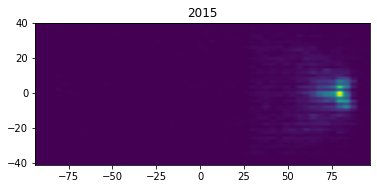

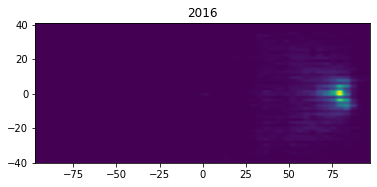

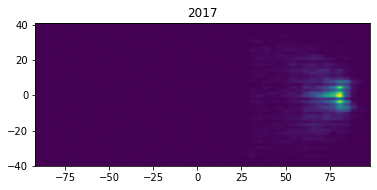

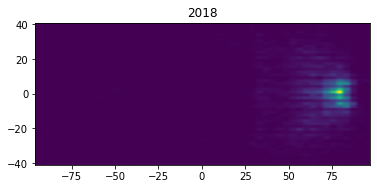

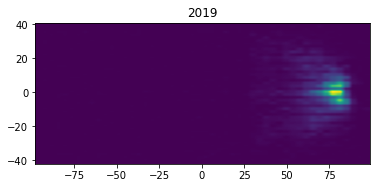

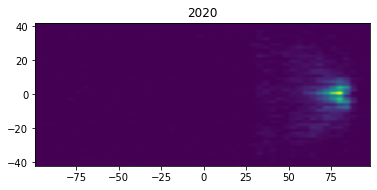

In [77]:
locGoalGroups = [g for n, g in goalLocDF.groupby(pd.Grouper(key='dateTime',freq='Y'))]
for x in locGoalGroups:
    heatmap, xedges, yedges = np.histogram2d(x['st_x'], x['st_y'], bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    plt.title(f"{x.dateTime.min().year}")
    plt.show()
